In [114]:
import pandas as pd
import numpy as np
import os
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
from tqdm import tqdm  

## Matrix Factorization using SVD

For this project, I'll be using restaurant rating data pulled from kaggle (https://www.kaggle.com/datasets/uciml/restaurant-data-with-consumer-ratings/data?select=rating_final.csv). In this data, users rated restaurants on a scale from 0-2 on food, service, and overall. This dataset is large enough to warrant testing SVD, but small enough to serve as a useful and flexible "toy" dataset for exploring the concept of matrix factorization. Let's pull in our data:

In [141]:
df = pd.read_csv('data/restaurant_data/rating_final.csv')

In [142]:
#see sample of data
df.sample(5, random_state=905)

,userID,placeID,rating,food_rating,service_rating
388,U1024,135042,1,2,1
1018,U1006,132954,1,1,1
823,U1003,132862,1,2,2
536,U1106,135064,2,2,2
69,U1108,135032,2,1,2


As noted above, users rated restaurants on two distinct dimensions as well as overall. For our purposes, we can simply take the overall rating.

In [48]:
#drop ancillary ratings
df.drop(columns=['food_rating','service_rating'], inplace=True)

Currently our data is in a "long" format, which only lists only user-restaurant combinations for which there are actually ratings. In order to conduct matrix factorization, we need, well, a matrix! We can create one by pivoting this data:

In [143]:
df_mx = pd.pivot_table(data=df,
               index='userID',
               columns='placeID',
               values='rating')

In [144]:
df_mx

placeID,132560,132561,132564,132572,132583,132584,132594,132608,132609,132613,...,135080,135081,135082,135085,135086,135088,135104,135106,135108,135109
userID,,,,,,,,,,,,,,,,,,,,,
U1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
U1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN
U1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
U1005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U1134,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
U1135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
U1136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We now have a "dense" matrix in the sense that we have all user-restaurant pairings included, though it's still "sparse" in the sense of many nulls. We'll account for that shortly.

For now, we want to make sure the values are centered on a per-user basis, meaning we subtract the user's mean rating from all of their individual ratings. This ensures that future calculations are accounting for the user's relative preference, since different ratings may be different across individuals depending on how generous or critical they are in general.

In [145]:
user_means = df_mx.mean(axis=1)

In [146]:
df_mx_demeaned = df_mx.sub(user_means, axis=0)

In [147]:
df_mx_demeaned

placeID,132560,132561,132564,132572,132583,132584,132594,132608,132609,132613,...,135080,135081,135082,135085,135086,135088,135104,135106,135108,135109
userID,,,,,,,,,,,,,,,,,,,,,
U1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.111111,NaN,NaN,NaN,NaN,NaN,NaN
U1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.400000,NaN,NaN,NaN,-0.400,NaN,NaN
U1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.384615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.125,NaN,NaN
U1005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U1134,NaN,NaN,NaN,-1.4375,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.437500,NaN,NaN,0.562500,NaN,NaN,NaN,NaN,NaN,NaN
U1135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000,NaN,NaN
U1136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### SVD

For now, we will start with k=20, a reasonable starting point for our number of features (130). However, we should understand that this selection is relatively arbitrary, and we will take a more systemic approach below.

In [148]:
k = 20

SVD needs numerical values to function properly, so we must replace the many nulls currently in our data with 0s, which will not be considered by the model. Because we de-meaned the data, any 0s remaining actually represent that users mean score, so the SVD not considering them should not negatively impact our model.

In [149]:
df_mx_sparse = np.nan_to_num(df_mx_demeaned.values)

In [150]:
#build SVD factors
U, sigma, Vt = svds(df_mx_sparse, k=k)

In this decomposition:
- **U** is a matrix where each row is a user (all users in our original data) and each of the *k* columns is a latent feature of the restaurants in the data (perhaps corresponding to things like nationality, spice-level, fanciness). Values rate the relative importance of each of those features to each user.
- **Sigma** is one-dimensional array representing the importance of each feature in user ratings.
- **Vt**, or V-transposed, is a 2D matrix where each row is one of the *k* features derived via the SVD, and each column is one of our 130 restaurants. Values represent the association between each restaurant and these latent features.

Because *sigma* is a 1D array as noted above, we need to convert it to a diagonal matrix in order to conduct necessary calculations:

In [161]:
sigma = np.diag(sigma)

By doing a successive dot product of U and sigma and then Vt, we get back a matrix corresponding in shape to the original rating matrix. The values for each row-column pair represent the predicted rating, but still de-meaned.

In [167]:
df_mx_hat_demeaned = np.dot(np.dot(U, sigma), Vt)

In [168]:
df_mx_hat_demeaned

array([[-3.90101122e-17, -7.11279631e-17, -5.50422905e-17, ...,
        -1.65233241e-02,  4.47822919e-02,  2.65454740e-17],
       [-5.96003334e-17, -1.04773881e-16, -9.37030994e-17, ...,
        -8.78839127e-02, -6.62835350e-03, -3.54418307e-17],
       [ 1.45654708e-16,  1.09679736e-16,  7.31208940e-17, ...,
        -2.52908788e-01, -6.03111932e-02, -9.64850615e-17],
       ...,
       [ 3.16514444e-17, -4.15291283e-19, -5.72028035e-17, ...,
         4.86720065e-02,  1.89618191e-02, -7.94092788e-17],
       [ 8.19098224e-17, -1.40734121e-16,  3.53492458e-17, ...,
        -1.02115327e-01, -1.83335438e-02, -9.87601551e-17],
       [-3.47512253e-18,  2.54117849e-18, -1.10797079e-17, ...,
        -2.90192506e-03, -2.49971656e-03, -1.47753327e-18]])

We can get the "true" prediction--based on our original 0-2 scale--by adding the user means back into this matrix:

In [169]:
df_mx_hat = df_mx_hat_demeaned + user_means.values.reshape(-1, 1)

Below we can see a quick distribution of all of our predictions:

<Axes: >

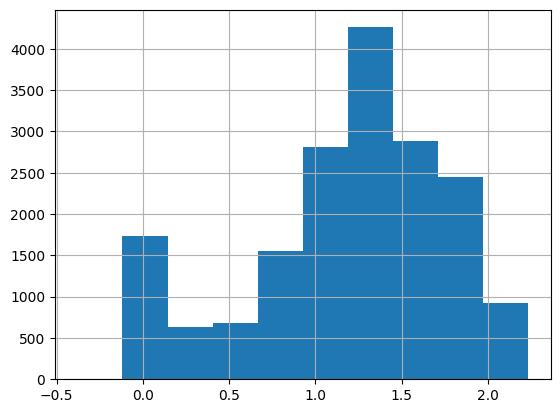

In [171]:
pd.Series(df_mx_hat.ravel()).hist()

### Prediction

Now that we have a full matrix of predicted scores, we can serve up top predicted restaurants to users. Let's build a quick function for doing this and test it on a user:

In [230]:
df_mx_hat_labels = pd.DataFrame(df_mx_hat, 
             index=df_mx.index,
             columns=df_mx.columns)

Functionally the user doesn't know these placeIDs, so we can merge in some practical info, and remove that anticipated score (as that as not typically reported directly to users, even if the overall ranking is):

In [239]:
df_places = pd.read_csv('data/restaurant_data/geoplaces2.csv', index_col='placeID')

In [243]:
#build out function
def pull_predictions_top5(user_id, df_pred, df_real, df_places):
    preds = df_pred.loc[user_id].sort_values(ascending=False)
    mask = df_real.loc[user_id].isna()
    unseen = preds[mask]

    top_5 = pd.DataFrame(unseen.iloc[:5]).join(df_places, how='left').drop(columns=user_id)

    return top_5

In [244]:
pull_predictions_top5('U1005', df_mx_hat_labels, df_mx, df_places)

,latitude,longitude,the_geom_meter,name,address,city,state,country,fax,zip,alcohol,smoking_area,dress_code,accessibility,price,url,Rambience,franchise,area,other_services
placeID,,,,,,,,,,,,,,,,,,,,
135082,22.151448,-100.915099,0101000020957F0000A29FAF95CD4958C1FEEEBB73A991...,la Estrella de Dimas,Villa de Pozos 192 Villa de Pozos,San Luis Potosi,SLP,Mexico,?,78421,No_Alcohol_Served,none,informal,no_accessibility,medium,?,familiar,f,closed,none
135025,22.149550,-100.977970,0101000020957F0000C7080D105C4858C108B4006AB4A3...,El Rincon de San Francisco,1a. de Lozada 1,San Luis Potosi,SLP,Mexico,?,?,No_Alcohol_Served,none,informal,no_accessibility,medium,?,familiar,f,closed,none
132885,22.179517,-100.958436,0101000020957F0000B1DA6F2D504458C112A26CA45B9C...,Hamburguesas saul,Av. Saan Luis enttre moctezuma y salinas,San Luis Potosi,San Luis Potosi,mexico,?,78433,No_Alcohol_Served,none,informal,completely,low,?,familiar,f,closed,none
132872,22.173596,-100.994603,0101000020957F0000942C3434384458C1C2D3499804A7...,Pizzeria Julios,?,s.l.p,mexico,?,?,?,No_Alcohol_Served,not permitted,informal,partially,medium,?,familiar,f,closed,none
135054,22.140626,-100.915657,0101000020957F000011E92CCE714B58C19BF8C0CA7592...,Restaurante y Pescaderia Tampico,Ricardo B. Anaya 2700 Estrella de Oriente,San Luis Potosi,SLP,Mexico,?,78000S,No_Alcohol_Served,none,informal,no_accessibility,high,?,familiar,f,closed,none


#### Evaluation

While the above may or may not be a good set of predictions for that one user, recommender systems cannot be effectively judged on such anecdotal evidence. Rather, we can evaluate ours as we would other ML models, by splitting our data into training and testing sets and judging the accuracy of predictions in aggregate. In this case, our evaluation metric is RMSE, which approximates how far off from the true value each prediction is. We'll start by using our original *k* of 20:

In [245]:
#set testing parameters
test_frac = 0.20
k = 20
random_state = 905

#train-test_split
rng = np.random.default_rng(random_state)
df["__rand"] = rng.random(len(df))

test_mask = df["__rand"] < test_frac
df_train  = df[~test_mask].drop(columns="__rand")
df_test   = df[ test_mask].drop(columns="__rand")

#pivot to matrix
df_mx = df_train.pivot_table(index="userID",
                             columns="placeID",
                             values="rating")

#demean
user_means = df_mx.mean(axis=1)
df_mx_demeaned = df_mx.sub(user_means, axis=0)
#make sparse
df_sparse = csr_matrix(np.nan_to_num(df_mx_demeaned.values, nan=0.0))

#build SVD
U, s, Vt = svds(df_sparse, k=k)
sigma = np.diag(s)

#reconstruct predictions
df_hat_demeaned = U @ sigma @ Vt
df_hat = df_hat_demeaned + user_means.values.reshape(-1, 1)

preds = pd.DataFrame(df_hat,
                     index=df_mx.index,
                     columns=df_mx.columns)

#evaluate held out ratings
y_true, y_pred = [], []

for row in df_test.itertuples(index=False):
    try:
        y_pred.append(preds.at[row.userID, row.placeID])
        y_true.append(row.rating)
    except KeyError:
        # cold-start user or item not present in training data
        continue

rmse = mean_squared_error(y_true, y_pred)
print(f"Rank-{k} SVD | Test RMSE = {rmse:.3f}")

Rank-20 SVD | Test RMSE = 0.415


This does not appear to be a bad result altogether. However, we can take a more systemic approach to try to determine a *k* value that results in stronger performance. Let's start by looping through different *k*s from 5-50 in 5-k increments (we wouldn't want to go much higher than this as we would start to approach our original feature count, defeating the purpose of decomposition:

In [248]:
#set testing parameters
test_frac = 0.20
random_state = 905

k_rmse_dict = dict()

for k in range(5,50,5): 
    #train-test_split
    rng = np.random.default_rng(random_state)
    df["__rand"] = rng.random(len(df))
    
    test_mask = df["__rand"] < test_frac
    df_train  = df[~test_mask].drop(columns="__rand")
    df_test   = df[ test_mask].drop(columns="__rand")
    
    #pivot to matrix
    df_mx = df_train.pivot_table(index="userID",
                                 columns="placeID",
                                 values="rating")
    
    #demean
    user_means = df_mx.mean(axis=1)
    df_mx_demeaned = df_mx.sub(user_means, axis=0)
    #make sparse
    df_sparse = csr_matrix(np.nan_to_num(df_mx_demeaned.values, nan=0.0))
    
    #build SVD
    U, s, Vt = svds(df_sparse, k=k)
    sigma = np.diag(s)
    
    #reconstruct predictions
    df_hat_demeaned = U @ sigma @ Vt
    df_hat = df_hat_demeaned + user_means.values.reshape(-1, 1)
    
    preds = pd.DataFrame(df_hat,
                         index=df_mx.index,
                         columns=df_mx.columns)
    
    #evaluate held out ratings
    y_true, y_pred = [], []
    
    for row in df_test.itertuples(index=False):
        try:
            y_pred.append(preds.at[row.userID, row.placeID])
            y_true.append(row.rating)
        except KeyError:
            # cold-start user or item not present in training data
            continue
    
    rmse = mean_squared_error(y_true, y_pred)

    k_rmse_dict[k] = rmse

<Axes: >

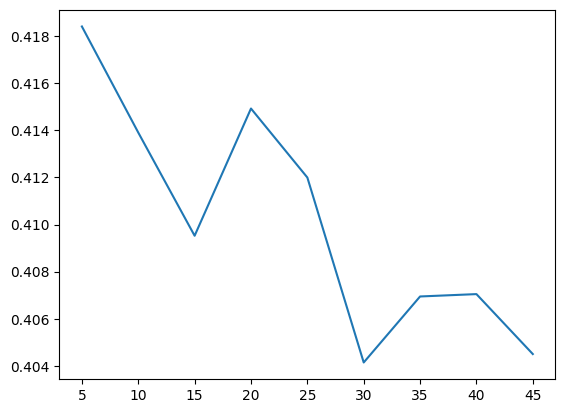

In [249]:
pd.Series(k_rmse_dict).plot()

Here we can see that RMSE was lowest around k=30, so we can narrow in further:

In [250]:
#set testing parameters
test_frac = 0.20
random_state = 905

k_rmse_dict = dict()

for k in range(20,40,1): 
    #train-test_split
    rng = np.random.default_rng(random_state)
    df["__rand"] = rng.random(len(df))
    
    test_mask = df["__rand"] < test_frac
    df_train  = df[~test_mask].drop(columns="__rand")
    df_test   = df[ test_mask].drop(columns="__rand")
    
    #pivot to matrix
    df_mx = df_train.pivot_table(index="userID",
                                 columns="placeID",
                                 values="rating")
    
    #demean
    user_means = df_mx.mean(axis=1)
    df_mx_demeaned = df_mx.sub(user_means, axis=0)
    #make sparse
    df_sparse = csr_matrix(np.nan_to_num(df_mx_demeaned.values, nan=0.0))
    
    #build SVD
    U, s, Vt = svds(df_sparse, k=k)
    sigma = np.diag(s)
    
    #reconstruct predictions
    df_hat_demeaned = U @ sigma @ Vt
    df_hat = df_hat_demeaned + user_means.values.reshape(-1, 1)
    
    preds = pd.DataFrame(df_hat,
                         index=df_mx.index,
                         columns=df_mx.columns)
    
    #evaluate held out ratings
    y_true, y_pred = [], []
    
    for row in df_test.itertuples(index=False):
        try:
            y_pred.append(preds.at[row.userID, row.placeID])
            y_true.append(row.rating)
        except KeyError:
            # cold-start user or item not present in training data
            continue
    
    rmse = mean_squared_error(y_true, y_pred)

    k_rmse_dict[k] = rmse

<Axes: >

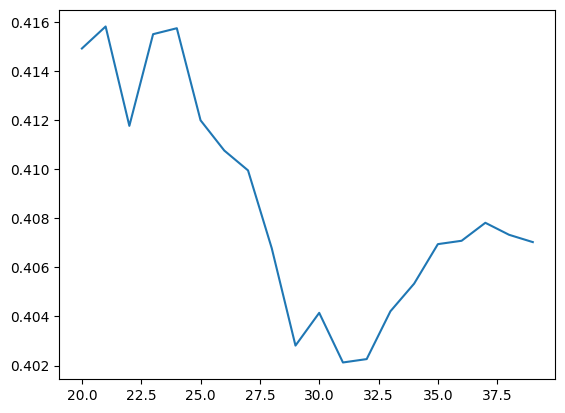

In [251]:
pd.Series(k_rmse_dict).plot()

Indeed, we see our best results coming in when k is about 30 or 31, meaning that is the optimal number of latent features to consider for our restaurant data.

#### Conclusion

All in all, we have built a decent recommendation system for the users and restaurants in our data. For future analyses, I would be interested in diving into our 30 reduced latent features which, while unlabeled by default, may reveal interesting patterns in the data upon closer inspection. Are people responding to different types of food? Different ambience? Even different location, which is reported in the data? Not being able to fully parse these features does not preclude an effective system, but it could provide powerful insights to not only improve the recommendation system, but also to feed back to the restaurants so they know which areas to improve on in order to position them for the greatest success moving forward.